In [1]:
# from jaref_bot.data.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI
import matplotlib.pyplot as plt

# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller, coint
# from lightweight_charts import Chart, JupyterChart

# import pandas as pd
import polars as pl
# import polars_ols as pls
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from tqdm.notebook import tqdm

from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

# exc_manager = ExchangeManager()
# exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [2]:
def calculate_profit(open_price, close_price, n_coins=None, usdt_amount=None, side='long', fee_rate=0.0002):
    if n_coins is None:
        n_coins = round(usdt_amount / open_price)
    
    usdt_open = n_coins * open_price
    open_fee = usdt_open * fee_rate

    usdt_close = n_coins * close_price
    close_fee = usdt_close * fee_rate
    # print(f'{open_fee=}; {close_fee=}')

    if side == 'long':
        profit = usdt_close - usdt_open - open_fee - close_fee
    elif side == 'short':
        profit = usdt_open - usdt_close - open_fee - close_fee
    return profit

#### Загрузка данных с ByBit

In [ ]:
# Гиперпараметры модели: roll_wind, std_coef (при каком отклонении от среднего входим в сделку)
download_period = '1h'
grouping_period = '24h'
roll_wind = 60
n_iters = 10
sym_1 = 'STRK_USDT'
sym_2 = 'XAI_USDT'

df_1 = await exc_manager.get_candles(symbol=sym_1, interval=download_period, n_iters=n_iters)
df_1 = df_1[0].sort_index()
df_2 = await exc_manager.get_candles(symbol=sym_2, interval=download_period, n_iters=n_iters)
df_2 = df_2[0].sort_index()

cols = ['Close']
df = df_1[cols].merge(df_2[cols], how='inner', on='Date', suffixes=(f'_{sym_1}', f'_{sym_2}'))
df = df.rename(columns={f'Close_{sym_1}': sym_1, f'Close_{sym_2}': sym_2})

stat_df = make_stat_df(df, sym_1, sym_2, grouping_period, roll_wind)

In [ ]:
stat_df.head(2)

In [ ]:
print_pair(stat_df, sym_1, sym_2)

#### Создание датафрейма с оконными функциями

In [ ]:
import polars as pl
import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
from tqdm.notebook import tqdm

from jaref_bot.utils.pair_trading import make_df_from_orderbooks, make_zscore_df_bulk, make_trunc_df, make_zscore_df

from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from numba import njit
from statsmodels.tsa.stattools import adfuller, coint

from jaref_bot.utils.pair_trading import get_lr_zscore, get_zscore

In [ ]:
token_1 = 'CELO'
token_2 = 'GRT'
method = 'dist'

start_time = datetime(2025, 8, 23, 18, 0, tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = datetime(2025, 8, 29, 18, 0, tzinfo=ZoneInfo("Europe/Moscow"))

end_time = datetime(2035, 10, 30, 23, 50, tzinfo=ZoneInfo("Europe/Moscow"))

if method == 'lr':
    return_spread = False
    log_spread = False
else:
    return_spread = True
    log_spread = True

In [ ]:
df_1 = db_manager.get_raw_orderbooks(exchange='bybit',
                                     market_type='linear',
                                     token=token_1 + '_USDT')
df_2 = db_manager.get_raw_orderbooks(exchange='bybit',
                                     market_type='linear',
                                     token=token_2 + '_USDT')

print(f'{token_1}: {df_1['time'].head(1).item()} - {df_1['time'].tail(1).item()}')
print(f'{token_2}: {df_2['time'].head(1).item()} - {df_2['time'].tail(1).item()}')

In [ ]:
df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time, 
                             return_spread=return_spread, log_spread=log_spread)

In [ ]:
df_hour = make_trunc_df(df, timeframe='1h', token_1=token_1, token_2=token_2, method='last')
df_4hour = make_trunc_df(df, timeframe='4h', token_1=token_1, token_2=token_2, method='last')
df_5min = make_trunc_df(df, timeframe='5m', token_1=token_1, token_2=token_2, method='last')
df_sec = make_trunc_df(df, timeframe='1s', token_1=token_1, token_2=token_2, start_date=valid_time, method='last')

In [ ]:
df_sec.head(2)

In [ ]:
%%time
spread_method = 'lr'

rows_buffer = []

hour4_winds = (6, 10, 14, 18)
hour1_winds = (12, 18, 24, 36, 48, 60, 72)
minute5_winds = (60, 90, 120, 240, 360, 480, 600)

max_hour1_wind = 2 * max(hour1_winds)
max_hour4_wind = 2 * max(hour4_winds)
max_minute5_wind = 2 * max(minute5_winds)
    
# --- Основной цикл --- 
try:
    for row in tqdm(df_sec[:].iter_slices(1), total=df_sec.height):
        data_dict = {'time': row['time'][0], 'ts': row['ts'][0], 
                     token_1: row[token_1][0], token_2: row[token_2][0]}

        # --- 4-ЧАСОВОЕ ОКНО ---
        hour4_stat = df_4hour.filter(pl.col('ts') < row['ts']).tail(max_hour4_wind)
        hour4_stat = hour4_stat.vstack(row)
        
        if method == 'lr':
            _, beta4, zscore4 = get_zscore(hour4_stat, token_1, token_2, winds=hour4_winds, method=method)
    
            for i, window in enumerate(hour4_winds):
                data_dict[f'beta_{window}_4h'] = beta4[i]
                data_dict[f'z_score_{window}_4h'] = zscore4[i]
        elif method == 'dist':
            means, stds, zscore4 = get_zscore(hour4_stat, token_1, token_2, winds=hour4_winds, method=method)

            for i, window in enumerate(hour4_winds):
                data_dict[f'z_score_{window}_4h'] = zscore4[i]
        
        # --- ЧАСОВОЕ ОКНО ---
        hour1_stat = df_hour.filter(pl.col('ts') < row['ts']).tail(max_hour1_wind)
        hour1_stat = hour1_stat.vstack(row)
        
        if method == 'lr':
            _, beta1, zscore1 = get_zscore(hour1_stat, token_1, token_2, winds=hour1_winds, method=method)
    
            for i, window in enumerate(hour1_winds):
                data_dict[f'beta_{window}_1h'] = beta1[i]
                data_dict[f'z_score_{window}_1h'] = zscore1[i]
        elif method == 'dist':
            means, stds, zscore1 = get_zscore(hour1_stat, token_1, token_2, winds=hour1_winds, method=method)

            for i, window in enumerate(hour1_winds):
                data_dict[f'z_score_{window}_1h'] = zscore1[i]
                
        # --- 5-МИНУТНОЕ ОКНО ---
        minute5_stat = df_5min.filter(pl.col('ts') < row['ts']).tail(max_minute5_wind)
        minute5_stat = minute5_stat.vstack(row)
        
        if method == 'lr':
            _, beta5, zscore5 = get_zscore(minute5_stat, token_1, token_2, winds=minute5_winds, method=method)
    
            for i, window in enumerate(minute5_winds):
                data_dict[f'beta_{window}_5m'] = beta5[i]
                data_dict[f'z_score_{window}_5m'] = zscore5[i]
        elif method == 'dist':
            means, stds, zscore5 = get_zscore(minute5_stat, token_1, token_2, winds=minute5_winds, method=method)

            for i, window in enumerate(minute5_winds):
                data_dict[f'z_score_{window}_5m'] = zscore5[i]

        rows_buffer.append(data_dict)
        
    result_df = pl.DataFrame(rows_buffer, infer_schema_length=None)
    rows_buffer = []

except KeyboardInterrupt:
    result_df = pl.DataFrame(rows_buffer, infer_schema_length=None)
    rows_buffer = []

In [ ]:
result_df.height

In [ ]:
result_df.tail(5)

In [ ]:
result_df.write_parquet(f'./data/{token_1}_{token_2}_{method}.parquet')

#### Исследование монет

In [1]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from tqdm.notebook import tqdm

from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from jaref_bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
from jaref_bot.utils.pair_trading import make_df_from_orderbooks
from jaref_bot.data.http_api import ExchangeManager, BybitRestAPI


In [2]:
# Если будет нужно отфильтровать датафрейм по времени

start_date = datetime(2025, 8, 23, 18, 0, tzinfo=ZoneInfo("Europe/Moscow"))
# end_date = datetime(2025, 8, 12, 8, 30, tzinfo=ZoneInfo("Europe/Moscow"))
# tdf = spread_df.filter((pl.col('time') > start_date) & (pl.col('time') < end_date))

In [4]:
# Задаём названия токенов для анализа
tokens = ['AKT', 'APT', 'ARB', 'ARKM', 'C98',  'CELO', 'CHR', 'ENJ', 'FIL', 'FLOW', 'GALA', 'GMT', 'GRT', 'GTC',
        'MANA', 'OGN', 'ONDO', 'ONG', 'OP', 'PHA', 'ROSE', 'SAND', 'STG', 'SNX', 'VET']

exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

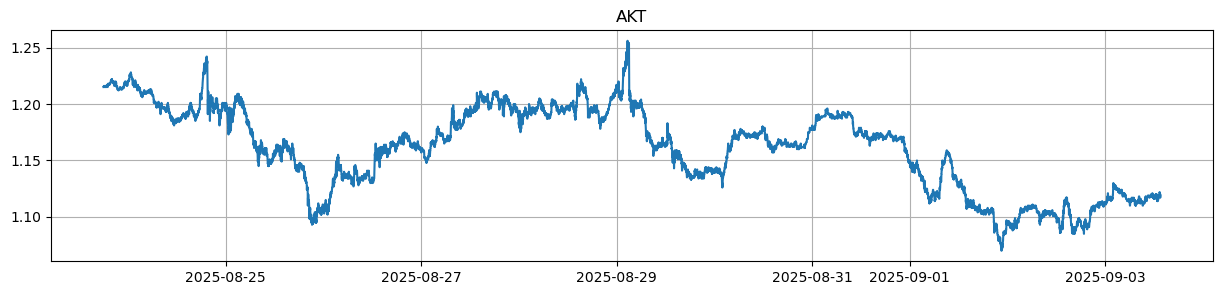

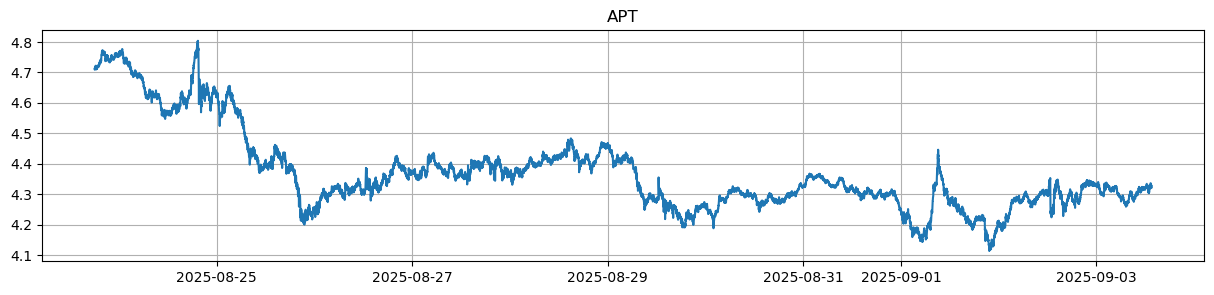

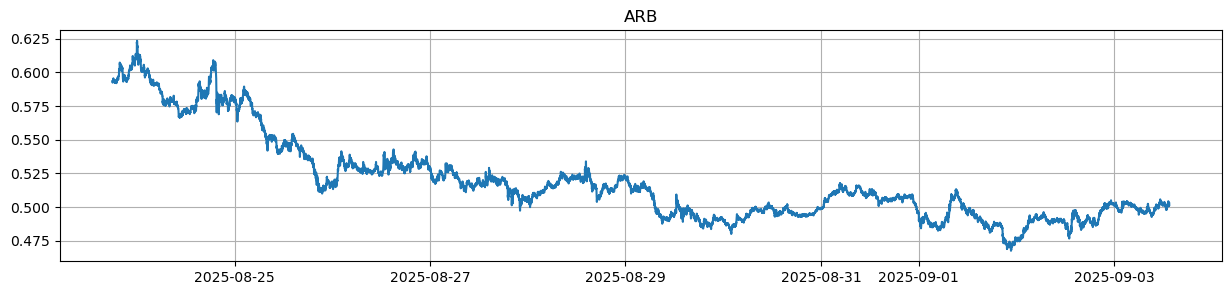

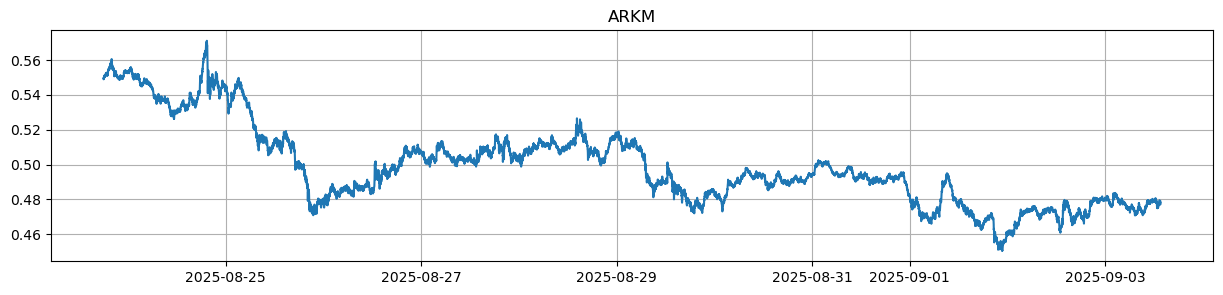

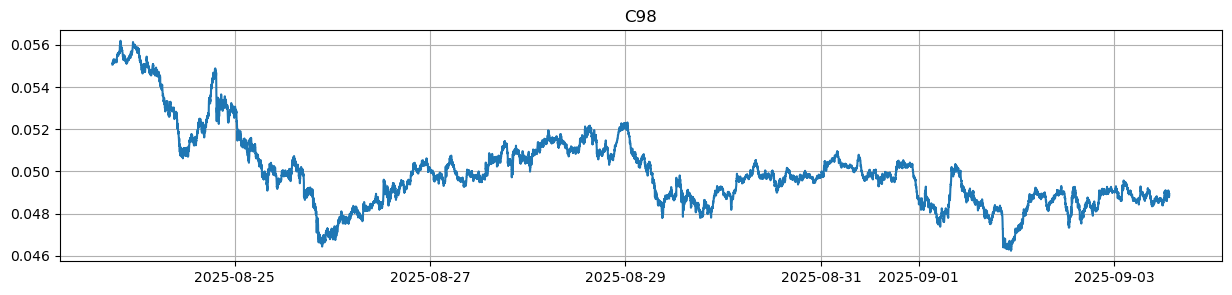

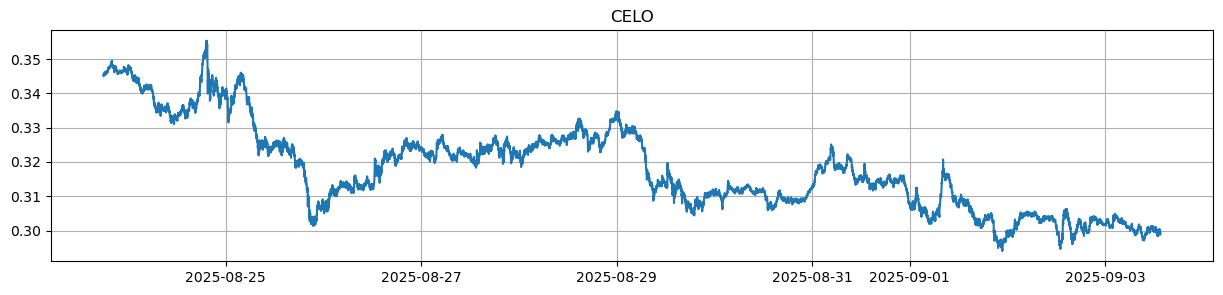

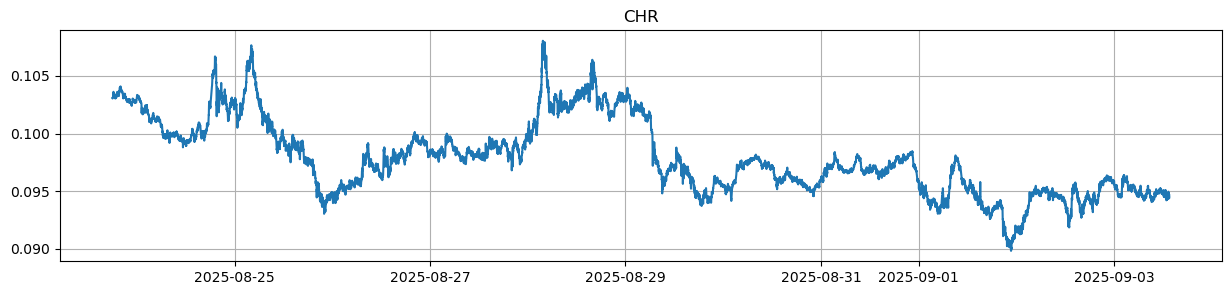

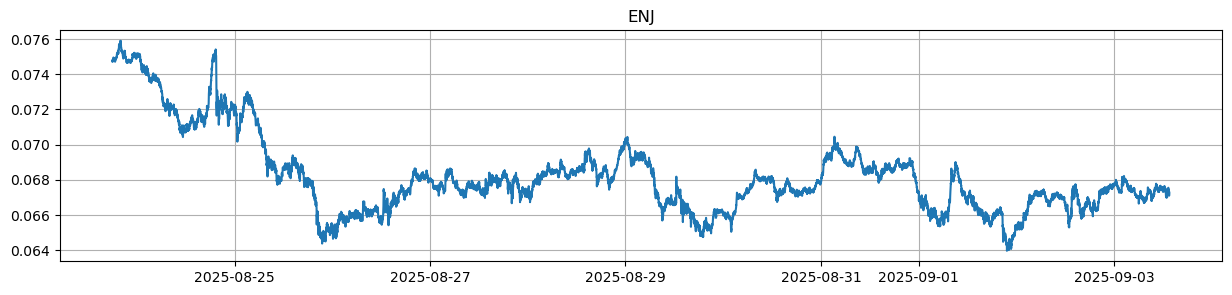

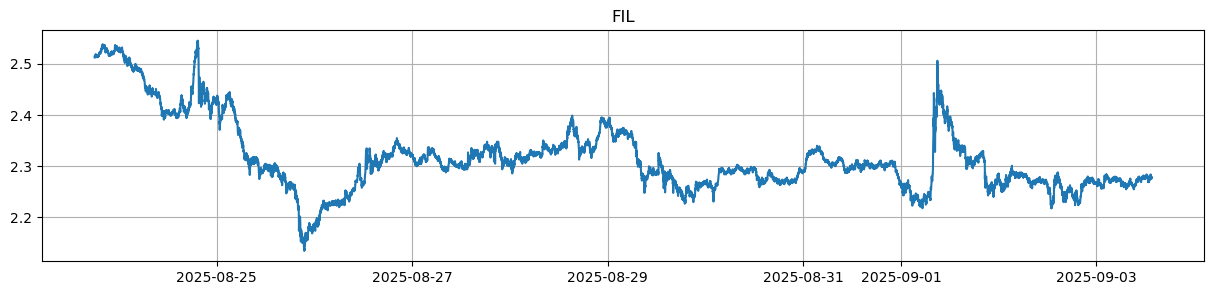

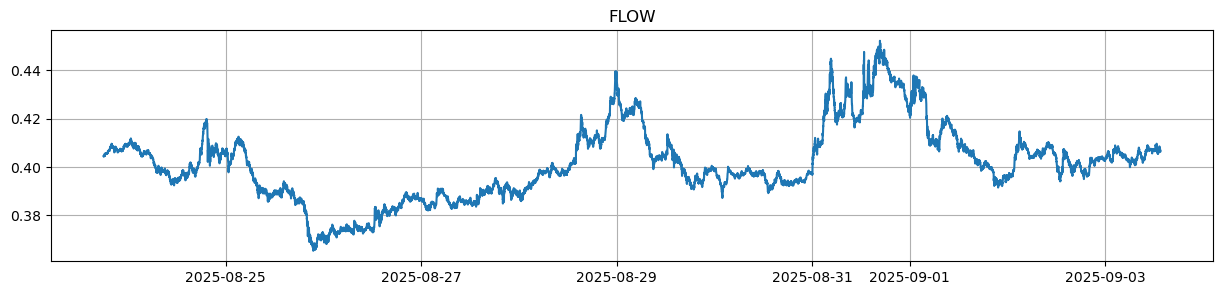

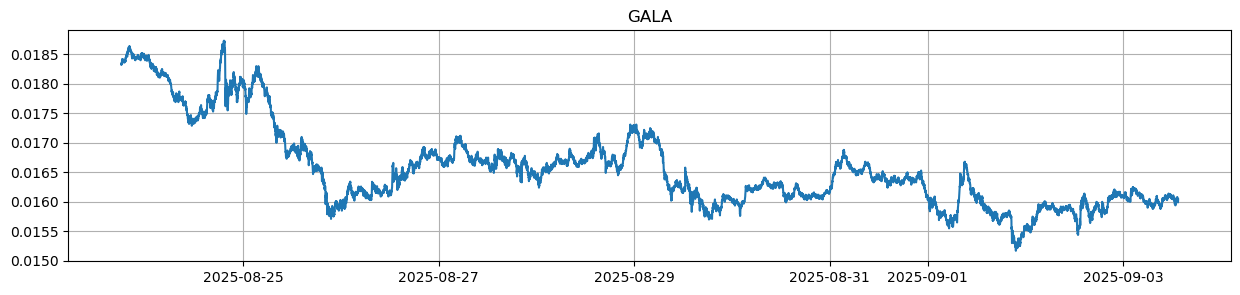

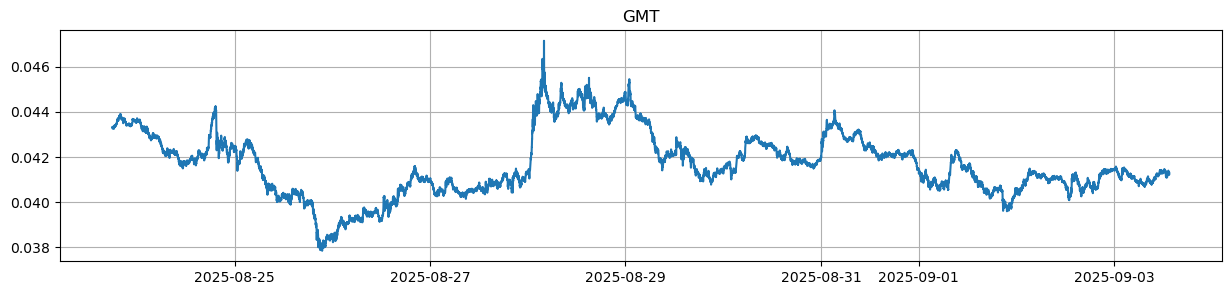

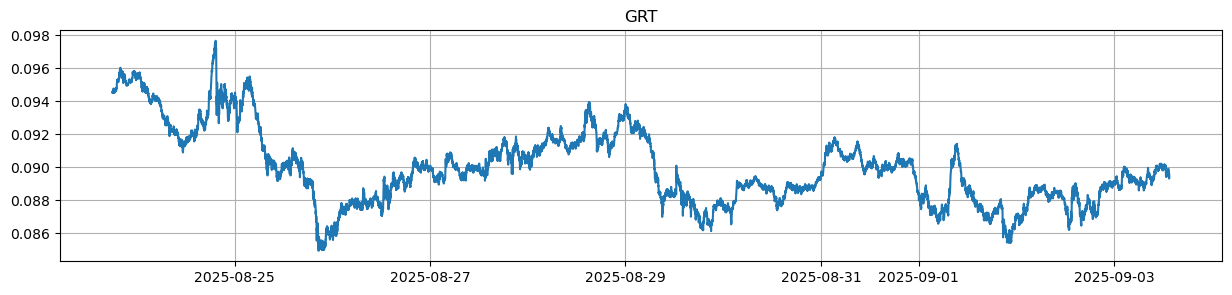

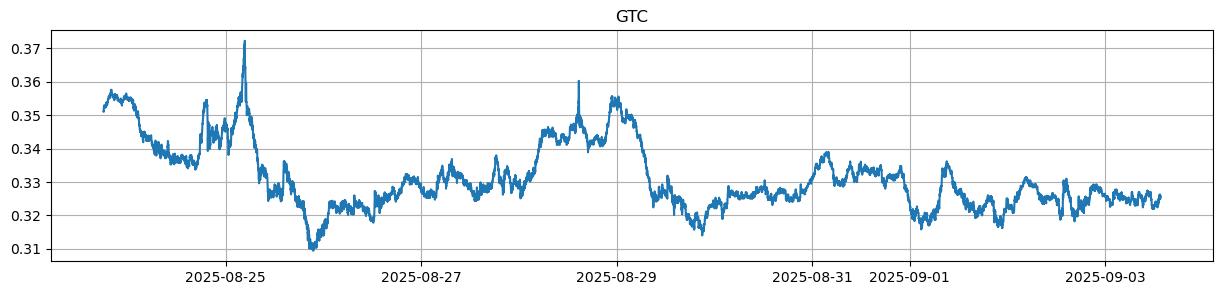

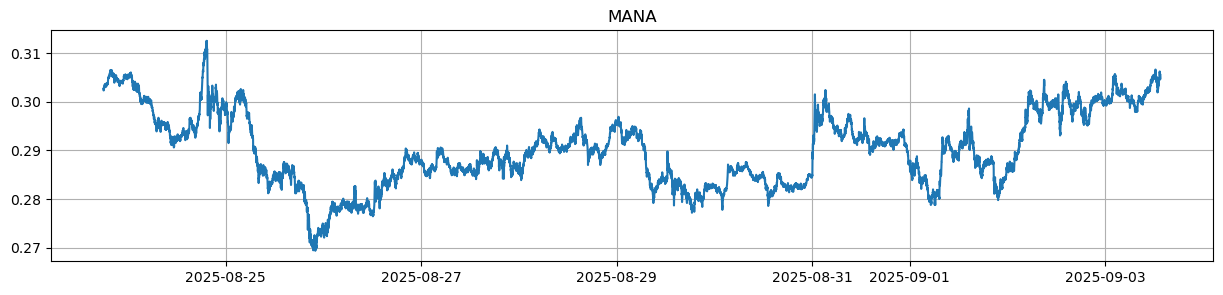

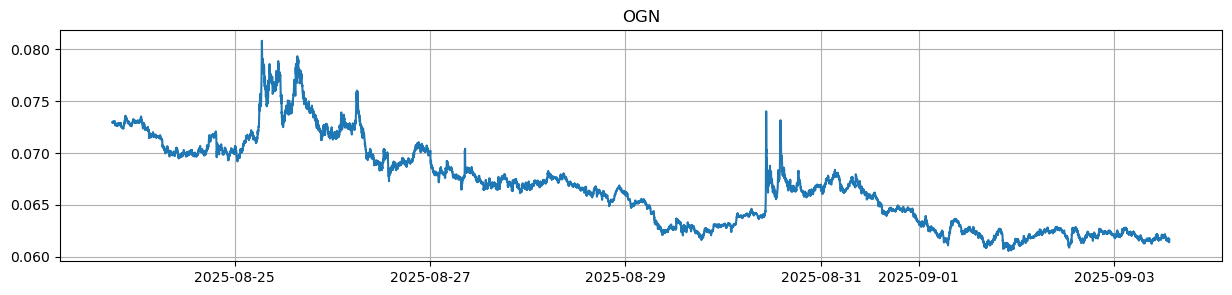

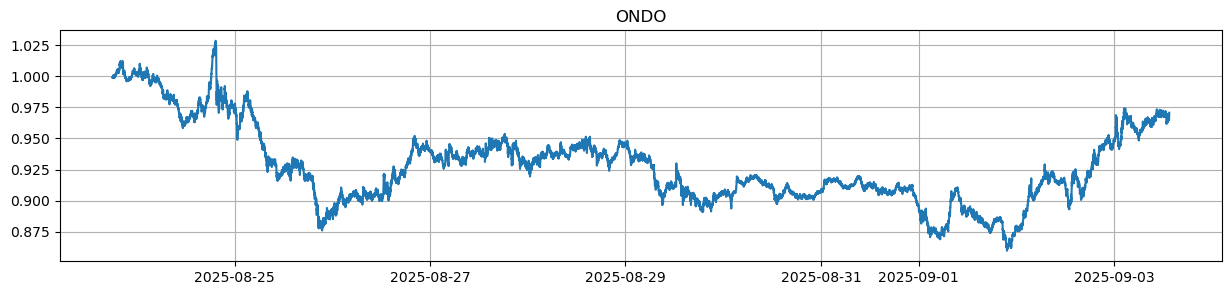

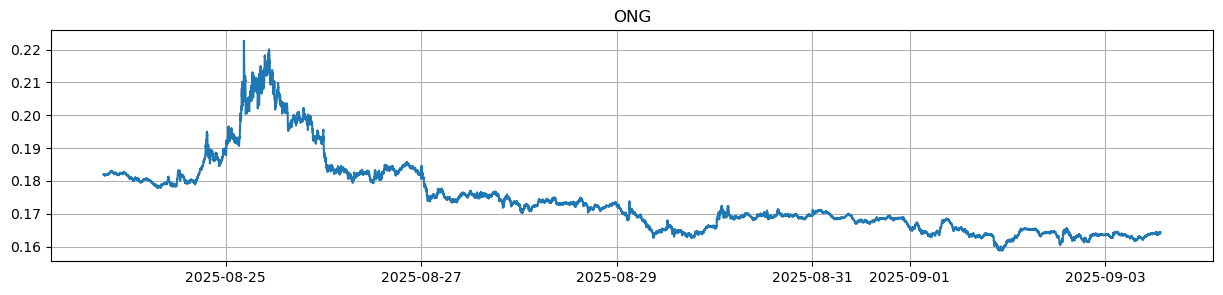

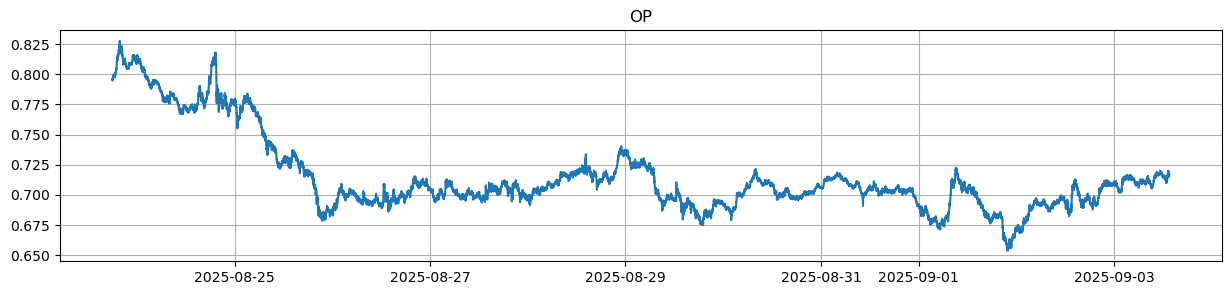

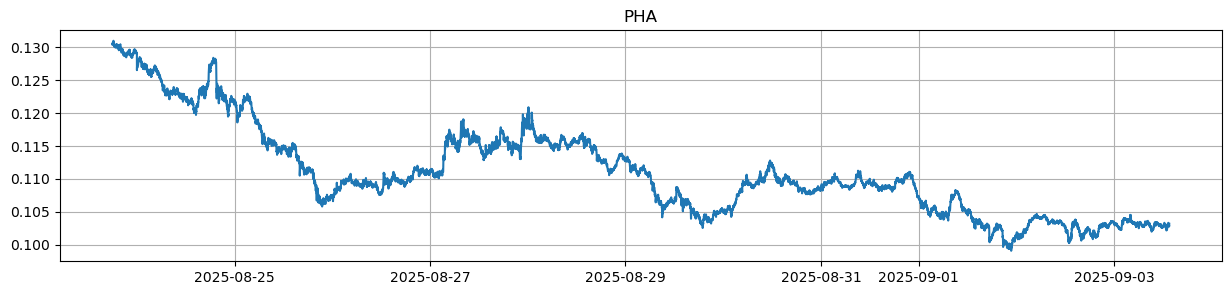

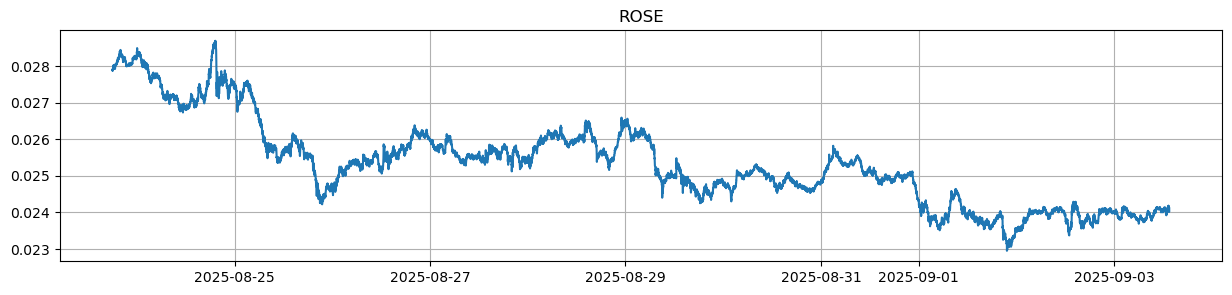

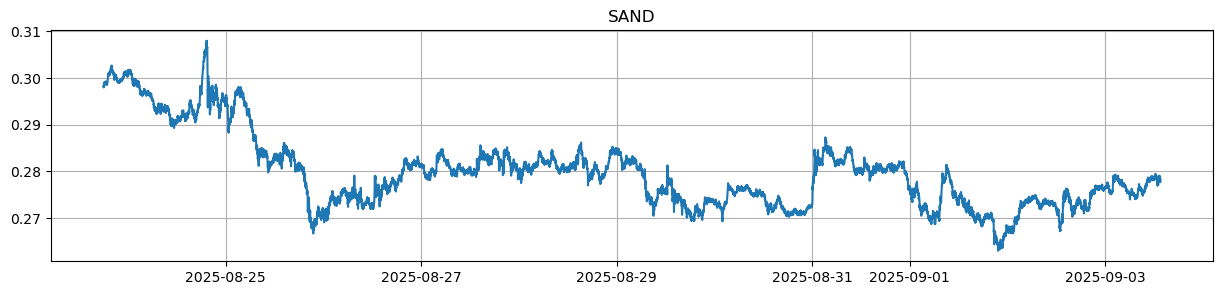

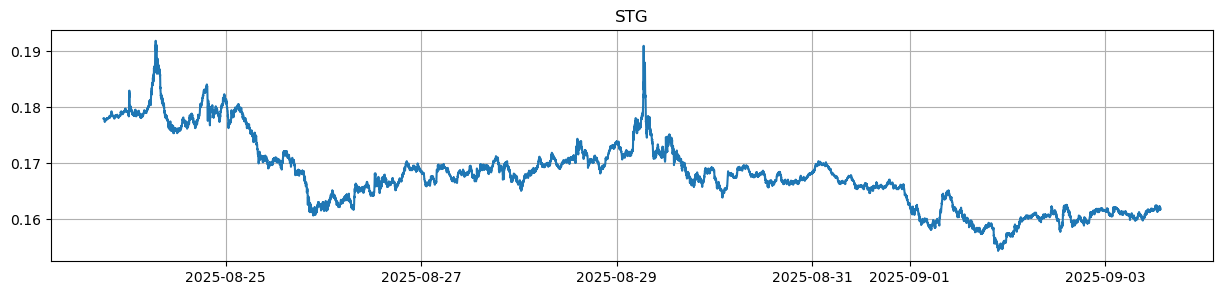

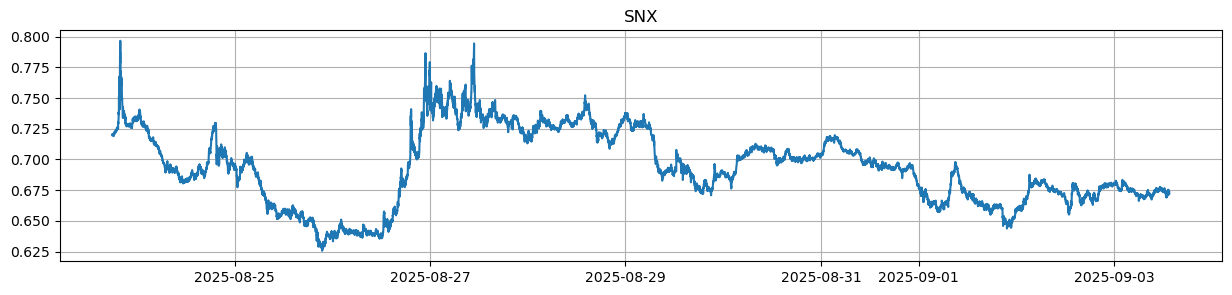

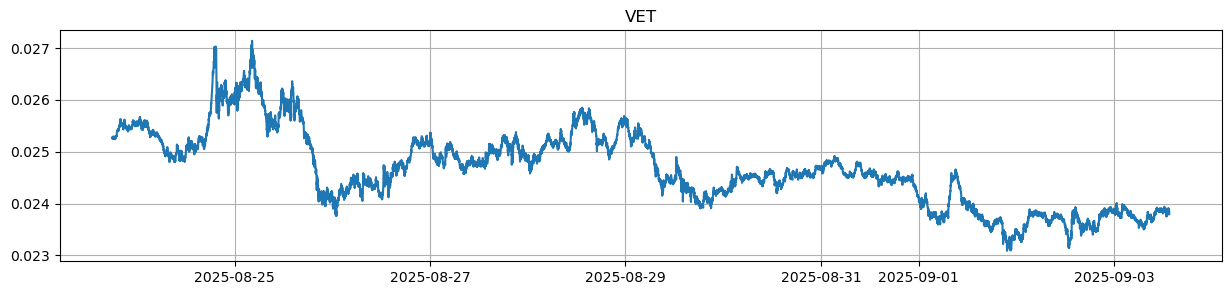

In [40]:
for token in tokens:
    df_token = db_manager.get_orderbooks(exchange='bybit', market_type='linear', symbol=token + '_USDT', interval='1min', start_date=start_date)

    daily_counts = df_token.group_by(pl.col("bucket").dt.date().alias("date")).agg(
        pl.len().alias("row_count")
    )
    
    plt.figure(figsize=(15, 3))
    plt.title(f'{token}')
    plt.plot(df_token['bucket'], df_token['bid_price'])
    plt.grid()
    plt.show()

In [41]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления 
dfs = []
token_dp = {}

for token in tokens:
    df_token = db_manager.get_orderbooks(exchange='bybit', market_type='linear', symbol=token + '_USDT', interval='1min', start_date=start_date)
    try:
        dp = len(
            coin_information['bybit_linear'][token + '_USDT']['qty_step']
            .to_eng_string()
            .split('.')[1]
        )
    except IndexError:
        dp = 0

    token_dp[token] = dp
    dfs.append(df_token)

In [42]:
# Создадим датафрейм, содержащий только цены, для анализа взаимосвязи монет
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
price_df.tail(1)

bucket,AKT,APT,ARB,ARKM,C98,CELO,CHR,ENJ,FIL,FLOW,GALA,GMT,GRT,GTC,MANA,OGN,ONDO,ONG,OP,PHA,ROSE,SAND,STG,SNX,VET
"datetime[μs, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-03 16:35:00 MSK,1.1195,4.3285,0.50275,0.47865,0.048945,0.29965,0.094535,0.067305,2.2795,0.40635,0.016045,0.041305,0.089555,0.32565,0.30545,0.061625,0.97065,0.16435,0.71835,0.103035,0.024105,0.27835,0.16215,0.67425,0.023865


In [43]:
# Нормируем значения
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

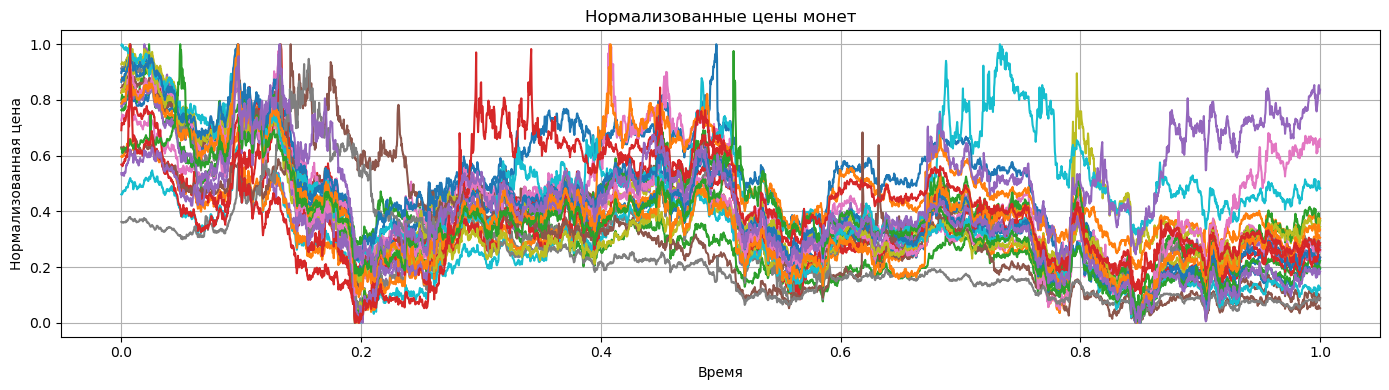

In [44]:
# Нарисуем график с нормализованными ценами
date_col = 'bucket' if 'bucket' in normed_df.columns else 'time'
price_cols = [c for c in normed_df.columns if c != date_col]

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df[date_col].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
# plt.legend()
plt.grid(True)
plt.tight_layout()

In [45]:
# Посчитаем евклидово расстояние между парами криптовалют
import itertools
import math

results = []
    
# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    results.append((col1, col2, distance))

In [46]:
pl.DataFrame(results, schema=["coin1", "coin2", "dist"], orient="row").sort('dist'
            ).filter((pl.col('coin1') == 'ARB') & (pl.col('coin2') == 'ONDO'))

coin1,coin2,dist
str,str,f64
"""ARB""","""ONDO""",8.347353


In [25]:
df.tail(2)

bucket,ts,GALA,ROSE,spread
"datetime[μs, Europe/Moscow]",i64,f64,f64,f64
2025-08-29 20:58:00 MSK,1756490280,0.015805,0.02445,-0.436304
2025-08-29 20:59:00 MSK,1756490340,0.015805,0.024445,-0.436099


In [22]:
token_1 = 'GALA'
token_2 = 'ROSE'

df_1 = db_manager.get_orderbooks(exchange='bybit', market_type='linear', symbol=token_1 + '_USDT', interval='1min')
df_2 = db_manager.get_orderbooks(exchange='bybit', market_type='linear', symbol=token_2 + '_USDT', interval='1min')

In [23]:
start_time = datetime(2025, 8, 23, 12, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 8, 29, 21, 0, tzinfo=ZoneInfo("Europe/Moscow"))

df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time, end_time=end_time)
cols = [col for col in df.columns if 'ask' in col or 'bid' in col]
df = df.drop(cols)
# df = make_zscore_df(df, token_1, token_2, wind=480).drop_nulls()
# coef = df[0][token_1].item() / df[0][token_2].item()

In [ ]:
# Нарисуем график с нормализованными ценами
date_col = 'bucket' if 'bucket' in df.columns else 'time'
price_cols = [c for c in df.columns if c != date_col]

plt.figure(figsize=(14, 4))
plt.plot(df[date_col], df[token_1], label=token_1);
plt.plot(df[date_col], coef * df[token_2], label=token_2);
plt.xlabel("Время")
plt.ylabel("Цена")
plt.title(f"Приведённые к одному масштабу цены монет. Coef: {coef:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
std = 2
upper_bound = df['mean'] + std * df['std']
lower_bound = df['mean'] - std * df['std']

plt.figure(figsize=(14, 2))
plt.plot(df[date_col], df['spread']);
plt.plot(df[date_col], upper_bound)
plt.plot(df[date_col], lower_bound)
plt.grid()

In [ ]:
train_time = datetime(2025, 8, 15, 3, 0, tzinfo=ZoneInfo("Europe/Moscow")) # За какое время рассчитываем mean & std для StandartScaler

spr_train = df.filter(pl.col(date_col) <= train_time)['spread'].to_numpy().reshape(-1, 1)
spr_test = df.filter(pl.col(date_col) > train_time)['spread'].to_numpy().reshape(-1, 1)

In [ ]:
scaler = StandardScaler()
scaler.fit(spr_train)
spr_normed = scaler.transform(spr_test).ravel()

In [ ]:
plt.figure(figsize=(14, 2))
plt.plot(spr_normed);
plt.title("Стандартизованный спред")
plt.grid()

#### Симуляция одной торговой пары

In [1]:
from jaref_bot.analysis.backtest.pair_trading import backtest
from jaref_bot.utils.pair_trading import make_df_from_orderbooks
from jaref_bot.analysis.strategy_analysis import analyze_strategy

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
from jaref_bot.data.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [38]:
token_1 = 'GTC'
token_2 = 'OP'
method = 'dist'

start_time = datetime(2025, 8, 23, 18, 0, tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = datetime(2025, 8, 29, 18, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2035, 9, 3, 10, 0, tzinfo=ZoneInfo("Europe/Moscow"))

spread_df = pl.read_parquet(f'./data/{token_1}_{token_2}_{method}.parquet')

In [39]:
spread_df.head(1)

time,ts,GTC,OP,z_score_6_4h,z_score_10_4h,z_score_14_4h,z_score_18_4h,z_score_12_1h,z_score_18_1h,z_score_24_1h,z_score_36_1h,z_score_48_1h,z_score_60_1h,z_score_72_1h,z_score_60_5m,z_score_90_5m,z_score_120_5m,z_score_240_5m,z_score_360_5m,z_score_480_5m,z_score_600_5m
"datetime[μs, Europe/Moscow]",i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-29 18:00:01 MSK,1756479601,0.32415,0.69045,-0.452555,-0.956841,-0.744869,-0.62947,0.170853,-0.604012,-0.891205,-1.243732,-1.024371,-0.844005,-0.579807,0.188311,0.020251,-0.382769,-1.08293,-1.409697,-1.335918,-0.928167


In [40]:
spread_df.tail(1)

time,ts,GTC,OP,z_score_6_4h,z_score_10_4h,z_score_14_4h,z_score_18_4h,z_score_12_1h,z_score_18_1h,z_score_24_1h,z_score_36_1h,z_score_48_1h,z_score_60_1h,z_score_72_1h,z_score_60_5m,z_score_90_5m,z_score_120_5m,z_score_240_5m,z_score_360_5m,z_score_480_5m,z_score_600_5m
"datetime[μs, Europe/Moscow]",i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-03 13:20:28 MSK,1756894828,0.32725,0.71785,-0.817386,-1.070795,-1.174625,-1.39672,-0.576845,-0.814336,-1.075638,-1.167414,-1.308493,-1.479083,-1.666365,-0.876853,-0.689498,-0.917238,-1.224666,-1.308264,-1.363652,-1.466296


In [41]:
df_1 = db_manager.get_raw_orderbooks(exchange='bybit',
                                     market_type='linear',
                                     token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_1 = df_1.with_columns(pl.col('time').dt.epoch('s').alias('ts'))
df_2 = db_manager.get_raw_orderbooks(exchange='bybit',
                                     market_type='linear',
                                     token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = df_2.with_columns(pl.col('time').dt.epoch('s').alias('ts'))

bid_ask_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time, end_time)
bid_ask_df = bid_ask_df.select('ts', f'{token_1}_bid_price', 
                               f'{token_1}_ask_price', 
                               f'{token_2}_bid_price', 
                               f'{token_2}_ask_price'
                              )

In [42]:
bid_ask_df.tail(2)

ts,GTC_bid_price,GTC_ask_price,OP_bid_price,OP_ask_price
i64,f64,f64,f64,f64
1756895444,0.3273,0.3274,0.7185,0.7186
1756895445,0.3273,0.3274,0.7185,0.7186


In [43]:
# Загружаем с биржи ByBit техническую информацию по монетам (шаг цены, округление цены в usdt etc.)
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

# Сохраним информацию о шаге цены монет в переменных
dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

In [44]:
search_space = (
            ('4h', 6), ('4h', 10), ('4h', 14), ('4h', 18),
            ('1h', 12), ('1h', 18), ('1h', 24), ('1h', 36), ('1h', 48), ('1h', 60), ('1h', 72),
            ('5m', 60), ('5m', 90), ('5m', 120), ('5m', 240), ('5m', 360), ('5m', 480), ('5m', 600)
        )

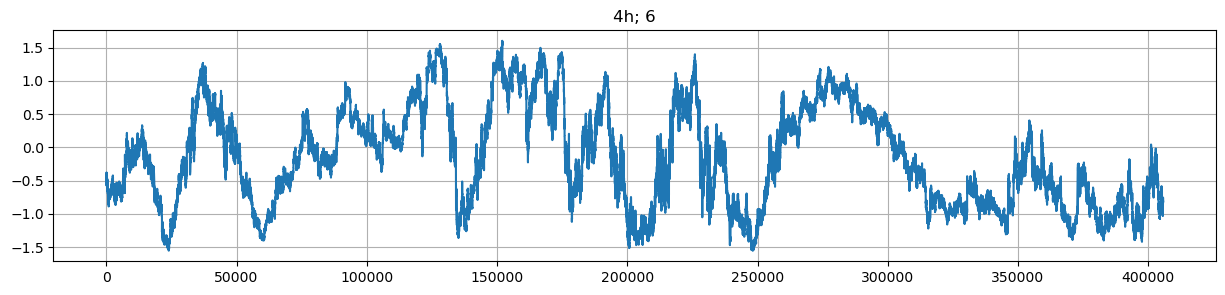

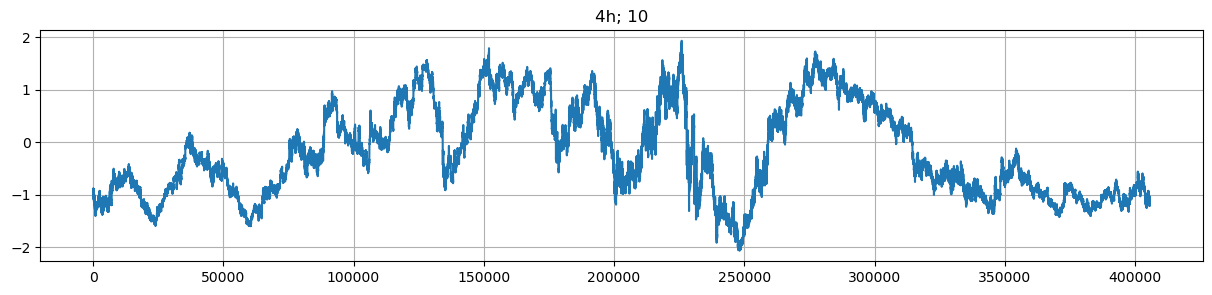

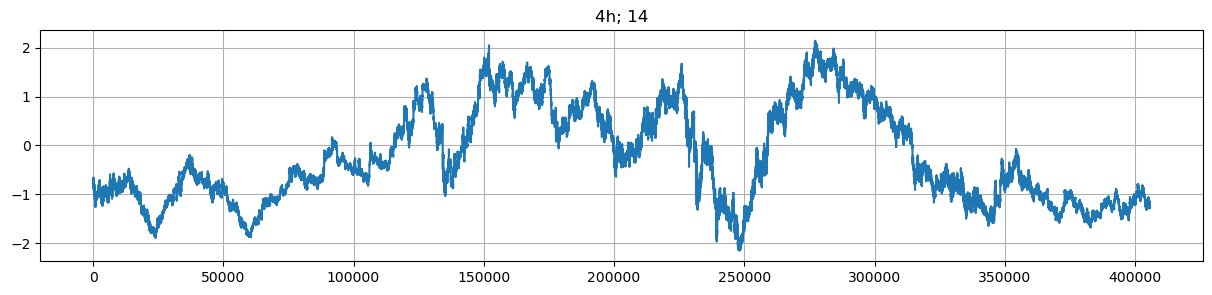

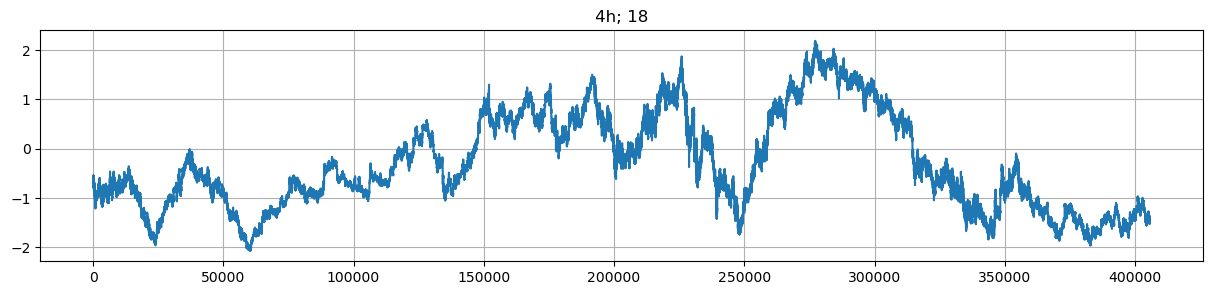

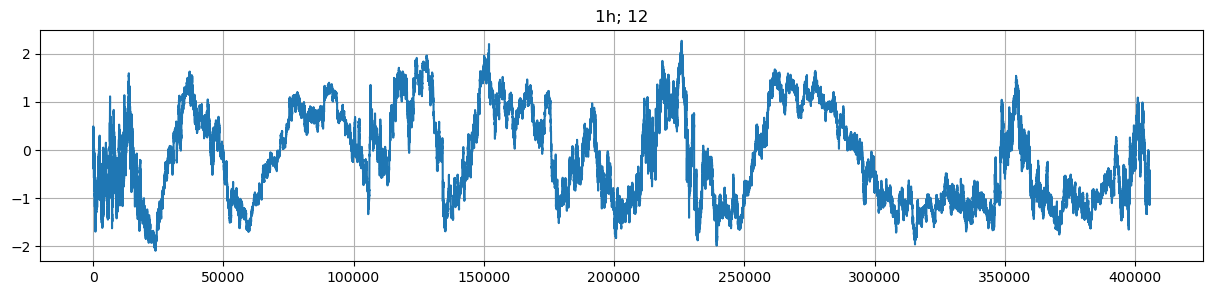

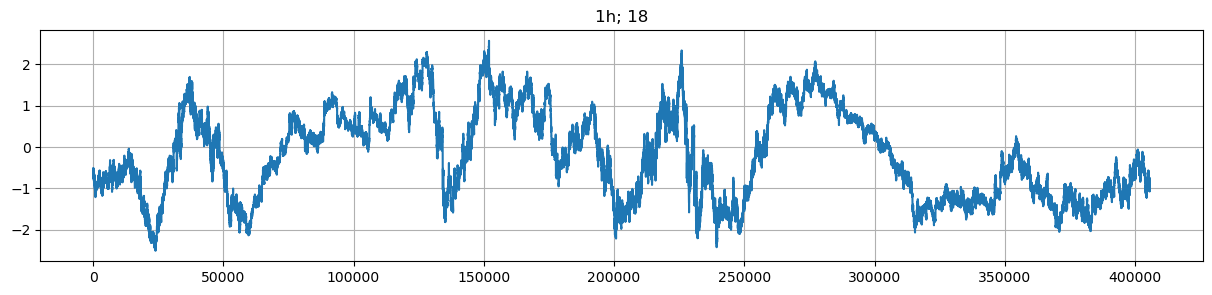

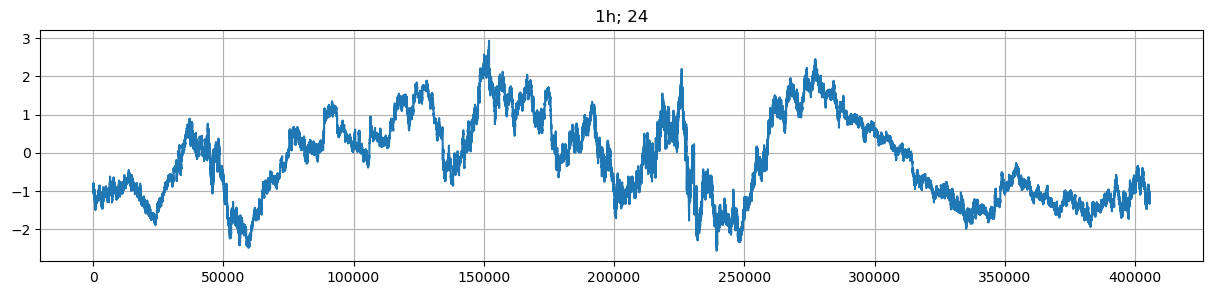

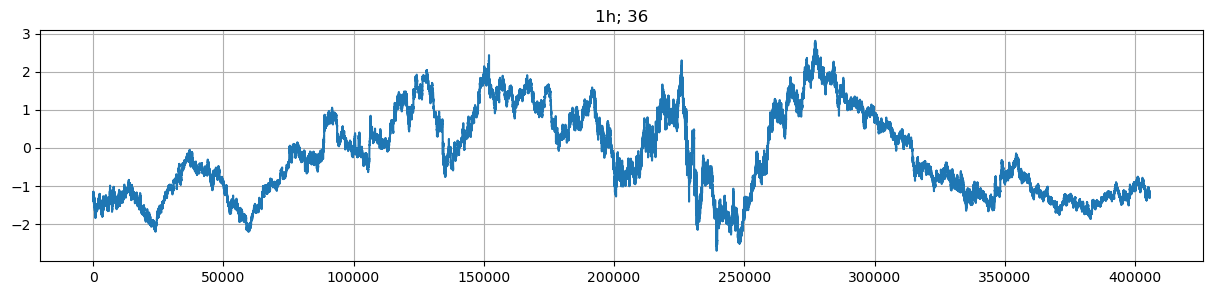

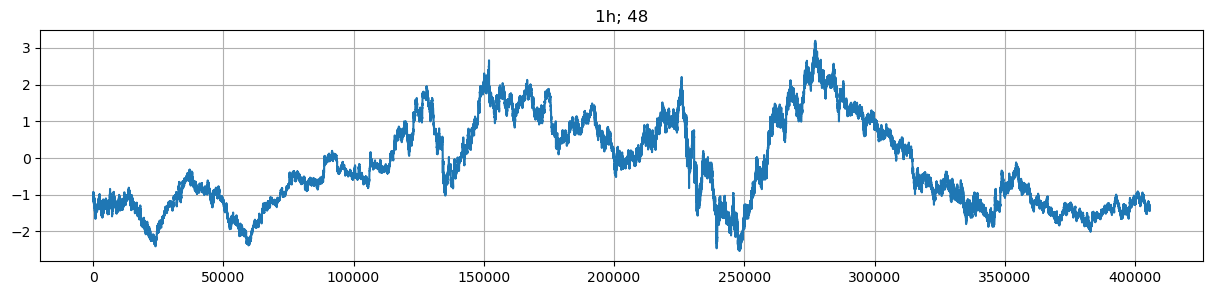

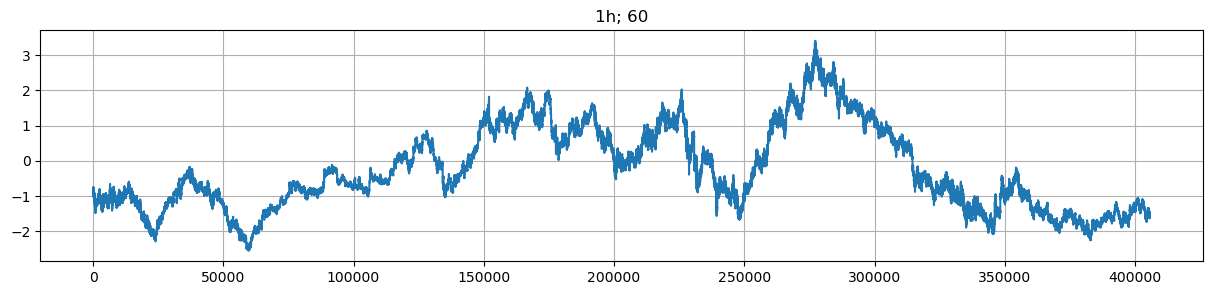

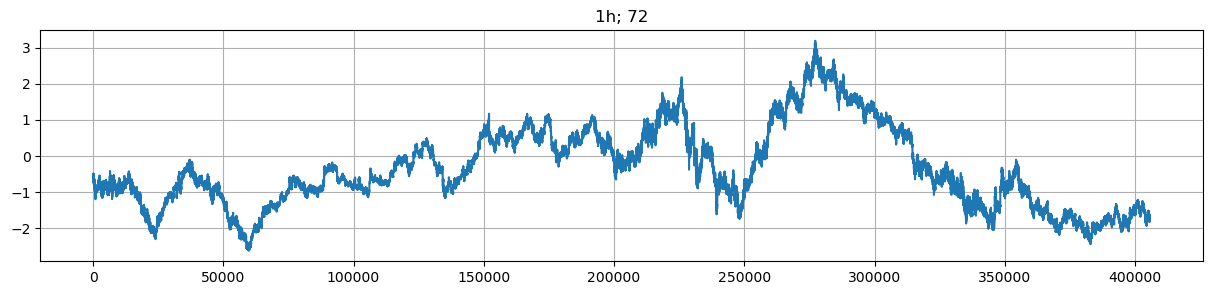

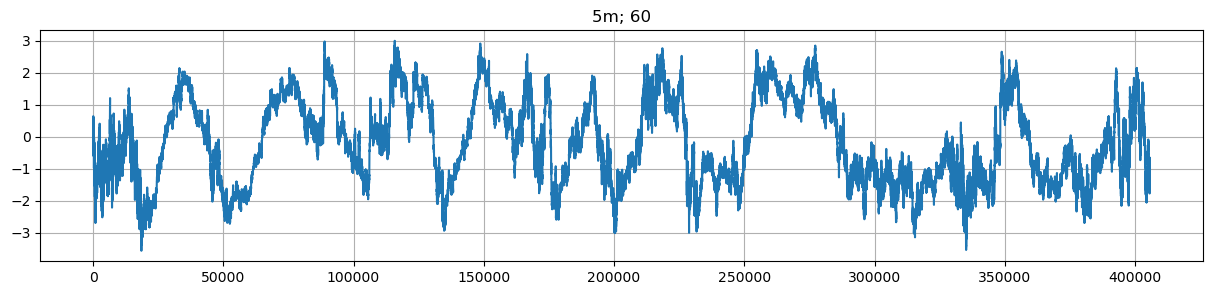

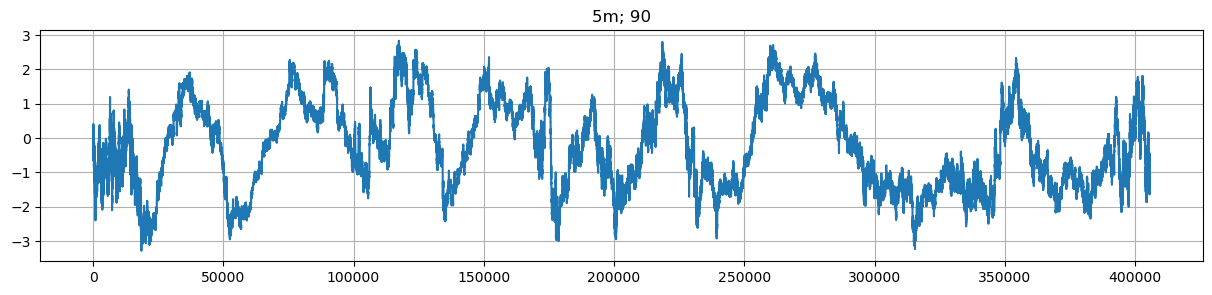

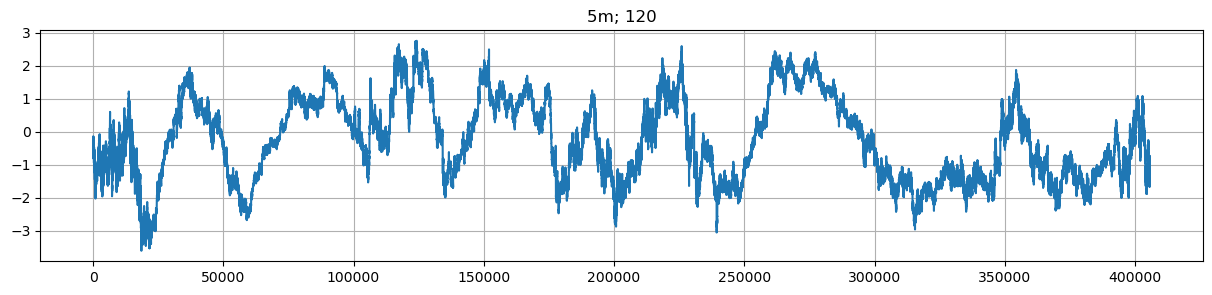

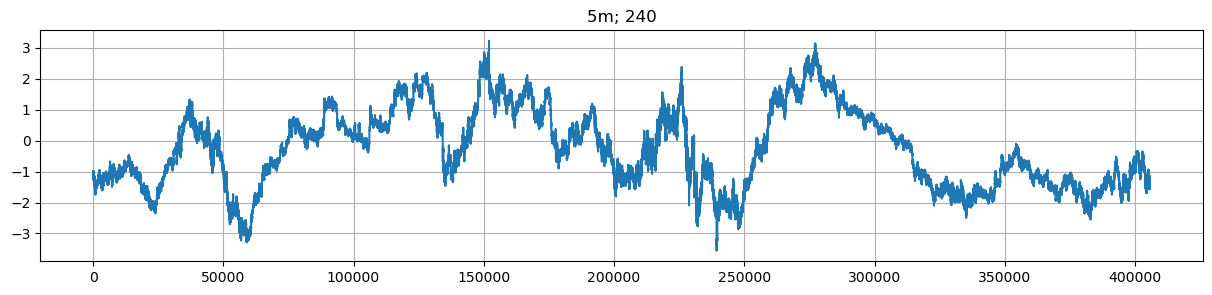

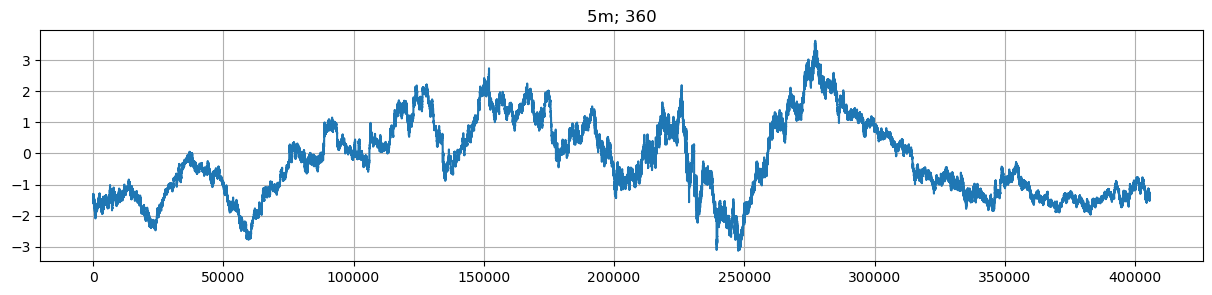

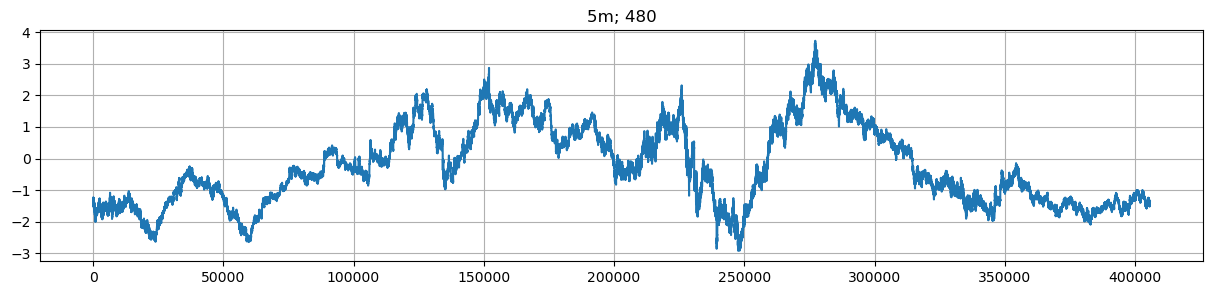

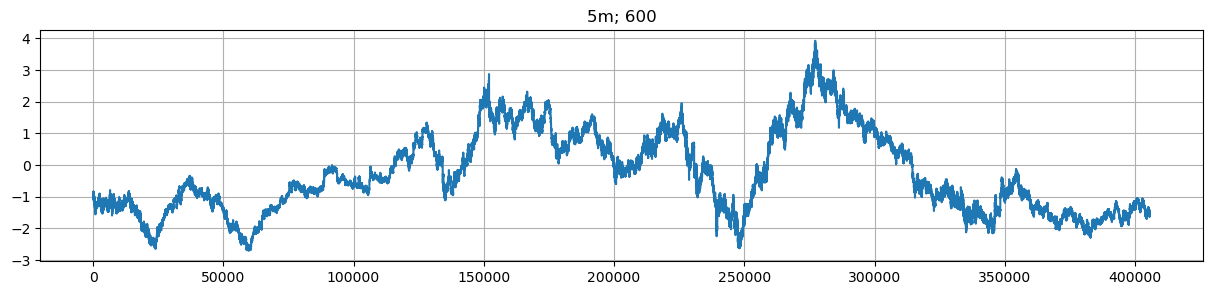

In [45]:
for tf, wind in search_space:
    col_name = f'z_score_{wind}_{tf}'
    try:
        df = spread_df.select('time', 'ts', col_name)
        df = df.rename({col_name: 'z_score'})
        df = df.join(bid_ask_df, on='ts')#.filter((pl.col('time') > start_time) & (pl.col('time') < valid_time))
    except pl.exceptions.ColumnNotFoundError:
        continue

    plt.figure(figsize=(15, 3))
    plt.title(f'{tf}; {wind}')
    plt.plot(df['z_score'])
    plt.grid()
    plt.show()

In [46]:
tf = '4h' # таймфрейм для агрегации цен
wind = 6 # размер окна для оконных функций

col_name = f'z_score_{wind}_{tf}'
df = spread_df.select('time', 'ts', col_name)
df = df.rename({col_name: 'z_score'})
df = df.join(bid_ask_df, on='ts')

In [47]:
params = {'low_in': -1.2, 'high_in': 1.2, 'low_out': -1.2, 'high_out': 1.2}
leverage = 2

trades_df = backtest(df, token_1, token_2, dp_1, dp_2, ps_1, ps_2, 
            thresh_low_in=params['low_in'], thresh_high_in=params['high_in'], 
            thresh_low_out=params['low_out'], thresh_high_out=params['high_out'], 
            long_possible=True, short_possible=True,
            method_in='direct', method_out='direct',
            balance=200, order_size=100, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
            sl_seconds = 60,
            leverage=leverage,
            verbose=2)

low_in: -1.2; high_in: 1.2; low_out: -1.2; high_out: 1.2. n_trades: 10.Profit: 55.03.
[ Open] 2025-08-30 00:00:02. Buy 633.4000000000001 GTC, Sell 292.1 OP
[Close] 2025-08-30 04:26:33. Profit: 4.20
[ Open] 2025-08-30 04:26:34. Sell 616.2 GTC, Buy 290.8 OP
[Close] 2025-08-30 10:05:31. Profit: 6.82
[ Open] 2025-08-30 10:05:32. Buy 614.5 GTC, Sell 279.8 OP
[Close] 2025-08-31 05:02:55. Profit: 6.77
[ Open] 2025-08-31 05:02:56. Sell 593.1 GTC, Buy 279.8 OP
[Close] 2025-08-31 08:24:37. Profit: 3.38
[ Open] 2025-08-31 08:24:38. Buy 605.5 GTC, Sell 280.2 OP
[Close] 2025-08-31 12:23:15. Profit: 4.35
[ Open] 2025-08-31 12:23:16. Sell 594.5 GTC, Buy 281.8 OP
[Close] 2025-09-01 03:07:30. Profit: 2.45
[ Open] 2025-09-01 03:07:31. Buy 620.0 GTC, Sell 289.5 OP
[Close] 2025-09-01 10:18:51. Profit: 3.37
[ Open] 2025-09-01 10:18:52. Sell 616.6 GTC, Buy 293.40000000000003 OP
[Close] 2025-09-01 14:12:33. Profit: 5.99
[ Open] 2025-09-01 14:12:34. Buy 609.4 GTC, Sell 281.2 OP
[Close] 2025-09-02 00:54:15. Pr

In [48]:
trades_df

open_ts,close_ts,qty_1,qty_2,open_price_1,close_price_1,open_price_2,close_price_2,pos_side,fees,profit_1,profit_2,total_profit,reason
i64,i64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64
1756501202,1756517193,633.4,292.1,0.3154,0.3242,0.6838,0.687,1,0.443043,5.351103,-1.154946,4.196157,1
1756517194,1756537531,616.2,290.8,0.3242,0.3251,0.687,0.7139,2,0.444114,-0.774634,7.59846,6.823826,1
1756537532,1756605775,614.5,279.8,0.3251,0.3368,0.7139,0.7138,1,0.443414,6.965944,-0.191729,6.774216,1
1756605776,1756617877,593.1,279.8,0.3368,0.3299,0.7138,0.7128,2,0.43702,3.874909,-0.499339,3.37557,1
1756617878,1756632195,605.5,280.2,0.3299,0.336,0.7128,0.7089,1,0.44086,3.471789,0.873682,4.34547,1
1756632196,1756685250,594.5,281.8,0.336,0.3222,0.7089,0.69,2,0.43203,7.988885,-5.542836,2.44605,1
1756685251,1756711131,620.0,289.5,0.3222,0.324,0.69,0.6807,1,0.438604,0.895646,2.4741,3.369746,1
1756711132,1756725153,616.6,293.4,0.324,0.3277,0.6809,0.7106,2,0.445557,-2.502431,8.489434,5.987003,1
1756725154,1756763655,609.4,281.2,0.3278,0.3181,0.7104,0.6534,1,0.427412,-6.127666,15.817475,9.689808,1


In [25]:
datetime.fromtimestamp(1756816940), datetime.fromtimestamp(1756882670)

(datetime.datetime(2025, 9, 2, 15, 42, 20),
 datetime.datetime(2025, 9, 3, 9, 57, 50))

datetime.datetime(2025, 9, 3, 13, 20, 28, tzinfo=zoneinfo.ZoneInfo(key='Europe/Moscow'))

In [55]:
end_date = df['time'][-1]

metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=200.0)

In [56]:
metrics

{'total_days': 4.81,
 'n_trades': 10,
 'duration_min': 12101,
 'duration_max': 68243,
 'duration_avg': 30151,
 'time_in_trade': 0.73,
 'stop_losses': 0,
 'liquidations': 0,
 'initial_balance': 200.0,
 'final_balance': 255.03,
 'total_perc_return': 27.52,
 'max_drawdown': 0.0,
 'max_profit': 9.69,
 'max_loss': 0,
 'avg_profit': 5.5,
 'profit_ratio': 366.667}

In [ ]:
token_1 = 'CELO'
token_2 = 'GRT'
method = 'lr'

In [ ]:
spread_df = pl.read_parquet(f'./data/{token_1}_{token_2}_{method}.parquet')

In [ ]:
spread_df.tail(3)

In [ ]:
f'z_score_{wind}_{tf}'

In [ ]:
wind = 12
tf = '4h'

spread_df.select('time', 'ts', f'z_score_{wind}_{tf}')

In [ ]:
# 0. Сделать проверку доступного объёма.
# 1. Проверить для разных способов вычисления скользящих значений (по цене закрытия или другими способами)
# 2. Проверить разные способы распределения денег между плечами ордера
# 3. Проверить, как изменится доходность, если размер ставки увеличивать с ростом банкролла

In [ ]:
time_1 = datetime(2025, 8, 26, 12, 00, 42, tzinfo=ZoneInfo("Europe/Moscow"))
time_2 = datetime(2025, 8, 27, 21, 12, 56, tzinfo=ZoneInfo("Europe/Moscow"))
df.filter((pl.col('time') > time_1) & (pl.col('time') < time_2)).drop('ts')

In [ ]:
tdf = df_5min.clone().drop('spread')

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
%%timeit
y = tdf['CELO'].to_numpy().reshape(-1, 1)
X = tdf['GRT'].to_numpy().reshape(-1, 1)

model = LinearRegression(fit_intercept=True)
model.fit(X, y)
beta = model.coef_

In [ ]:
beta

In [ ]:
%%timeit
n = tdf.height
agg = tdf.select(
    pl.col("GRT").mean().alias("mean_x"),
    pl.col("CELO").mean().alias("mean_y"),
    (pl.col("GRT") * pl.col("CELO")).sum().alias("sum_xy"),
    (pl.col("GRT") ** 2).sum().alias("sum_x2"),
)

mean_x = agg["mean_x"][0]
mean_y = agg["mean_y"][0]
sum_xy = agg["sum_xy"][0]
sum_x2 = agg["sum_x2"][0]

cov_xy = sum_xy / n - mean_x * mean_y
var_x = sum_x2 / n - mean_x ** 2

beta = cov_xy / var_x
# alpha = mean_y - beta * mean_x

In [ ]:
%%timeit

tdf1 = tdf.with_columns(
    # Ковариация и дисперсия для расчета beta
    pl.cov("CELO", "GRT").alias("covariance"),
    pl.var("GRT").alias("variance_GRT"),
)
beta = tdf1['covariance'][0] / tdf1['variance_GRT'][0]

In [ ]:
beta

In [ ]:
import polars_ols as pls   # регистрирует namespace .least_squares

In [ ]:
%%timeit
tdf.select(
    pl.col("CELO").least_squares.ols(pl.col("GRT"), mode="coefficients", add_intercept=True)
).unnest("coefficients")['GRT'][0]

In [ ]:
beta, alpha

In [ ]:
wind = 12
y_col = 'CELO'
x_col = 'GRT'

coeffs_expr = pl.col(y_col).least_squares.rolling_ols(pl.col(x_col), window_size=wind, add_intercept=True, mode="coefficients")

In [ ]:
tdf.tail(3)

In [ ]:
def calc_spread_beta(window: pl.DataFrame) -> dict:
    if window.height < wind:
        return {"spread": None, "beta": None, "zscore": None}
    
    X = window["GRT"].to_numpy().reshape(-1, 1)
    y = window["CELO"].to_numpy()
    reg = LinearRegression().fit(X, y)
    beta = reg.coef_[0]

    # считаем спред на последней точке окна
    spread_series = y - beta * X.flatten()
    spread = spread_series[-1]

    mean_spread = spread_series.mean()
    std_spread = spread_series.std(ddof=1)

    if std_spread == 0:
        zscore = 0.0
    else:
        zscore = (spread - mean_spread) / std_spread

    return {"spread": spread, "beta": beta, "zscore": zscore}